In [1]:
import datetime
import os
import pandas as pd
import xarray as xr
import numpy as np
import geopandas as gpd
import glob 
import gc
import matplotlib as mpl
import matplotlib.pyplot as plt 
from matplotlib import cm
from matplotlib.gridspec import GridSpec
from matplotlib import colors
import cmcrameri.cm as ccm
from fos.dirs import projectdir, basedir, coorddir, snoteldir
import scipy
plt.style.use('style.mplstyle')


/global/homes/c/cowherd/.conda/envs/fos/lib/python3.11/site-packages/pyproj/__init__.py:90: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


In [194]:
coorddir

'/global/cfs/cdirs/m4099/fate-of-snotel/wrfdata/meta/meta_new/'

In [2]:
coords = xr.open_dataset(f'{coorddir}wrfinput_d02')
lat = coords['XLAT'][0]
lon = coords['XLONG'][0]

In [ ]:
## compare the annual snowpack data from 1985 to 2015 from the UCLA reanalysis, SNOTEL sites, and WRF data. include the non BC data as well??

In [176]:
## ucla data
ucla_snotel_data = scipy.io.loadmat('SNOTEL_SWE_WY1985_2021_high_res.mat')
## snotel data
snotel_from_WRF_BC = xr.open_dataset('all_snotelWRF_365.nc').rename({'__xarray_dataarray_variable__':'swe'})


In [170]:
snotelmeta = pd.read_csv(snoteldir + 'snotelmeta.csv')

snotel_gdf = gpd.GeoDataFrame(data = {'site_name':snotelmeta.site_name,
                                     'elev': snotelmeta.elev,
                                     'site_number':snotelmeta.site_number,
                                     'state':snotelmeta.state,
                                     'namestr':snotelmeta.namestr,
                                     'startdt':snotelmeta.startdt}, geometry = gpd.points_from_xy(snotelmeta.lon, snotelmeta.lat))
snotel_no_ak = snotel_gdf[snotel_gdf.state != "AK"]


In [171]:
## what's the list of SNOTEL sites?
ucla_snotels = list(ucla_snotel_data['SNOTEL'][0][0][0].flatten()) ## 858 stations
file_list = glob.glob("../../snoteldata/snotel*.csv")
my_snotels= [fn.split('.csv')[0].split('snotel')[-1] for fn in file_list] ## 812 stations + snotelmeta
my_snotels = [int(item) for item in my_snotels if item != 'meta']
shared_entries = list(set(my_snotels).intersection(ucla_snotels))
# Find the entries that are not in one of the lists
unique_to_my_snotels = list(set(my_snotels).difference(ucla_snotels))
unique_to_ucla_snotels = list(set(ucla_snotels).difference(my_snotels))
## now make a list of ind for the shared_entries

filtered_snotel = snotel_no_ak[snotel_no_ak['site_number'].isin(shared_entries)]

points = zip(filtered_snotel.geometry.x, filtered_snotel.geometry.y)
x_indices, y_indices = [], []

for point in points:
    longitude, latitude = point
    distances = np.sqrt((lat.values - latitude) ** 2 + (lon.values - longitude) ** 2)
    min_indices = np.unravel_index(np.argmin(distances), distances.shape)
    x_indices.append(min_indices[0])
    y_indices.append(min_indices[1])


In [134]:
snotel_data = []
for num in shared_entries:
    file = f"../../snoteldata/snotel{num}.csv"
    df = pd.read_csv(file, parse_dates = True)
    df['Date'] = pd.to_datetime(df['datetime'])
    df = df[(df['Date'].dt.year >= 1980) & (df['Date'].dt.year <= 2015)]
    snotel_data.append(df) 
snotel_df = pd.concat([df.set_index('Date')['SWE'] for df in snotel_data], axis=1)
meansnotel = snotel_df.groupby(snotel_df.index.dayofyear).mean()

gc.collect()

288

In [277]:
'''
tmpmean = snotel_from_WRF_BC.mean(dim = 'gcm').mean(dim = 'site')
wrf_snotel_daily = tmpmean.resample(time='D').mean()
wrf_snotel_daily_mean = wrf_snotel_daily.groupby('time.dayofyear').mean('time')
wrf_snotel_daily_sd = wrf_snotel_daily.groupby('time.dayofyear').std('time')

## by-site snotel from wrf ## 
by_gcm = snotel_from_WRF_BC.mean(dim = 'site').resample(time='D').mean().groupby('time.dayofyear').mean('time')
'''

In [183]:
wrf_snotel_daily_mean = snotel_from_WRF_BC.mean(dim = 'site').mean(dim = 'gcm').swe

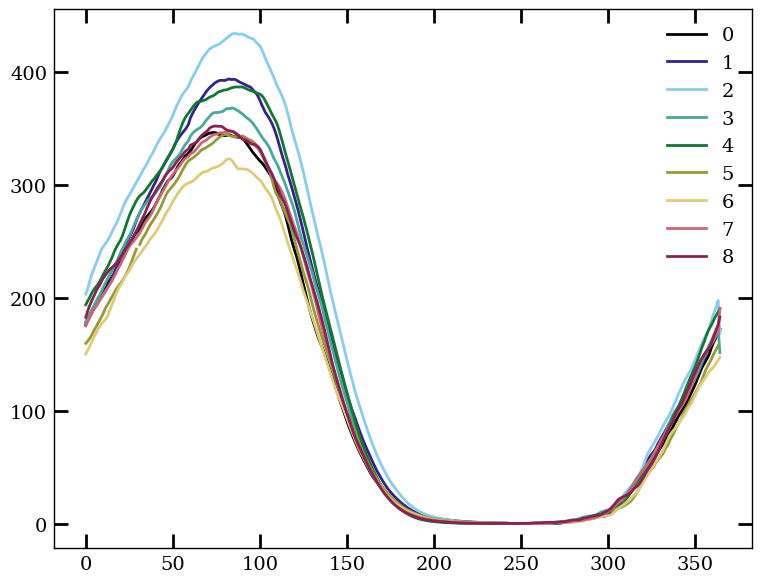

In [180]:
fig,ax = plt.subplots()
for gcm in snotel_from_WRF_BC.gcm:
    tmpdata = snotel_from_WRF_BC.sel(gcm = gcm).mean(dim = 'site')
    plt.plot(tmpdata.dayofyear, tmpdata['swe'], label = gcm.values.flatten()[0])
plt.legend()


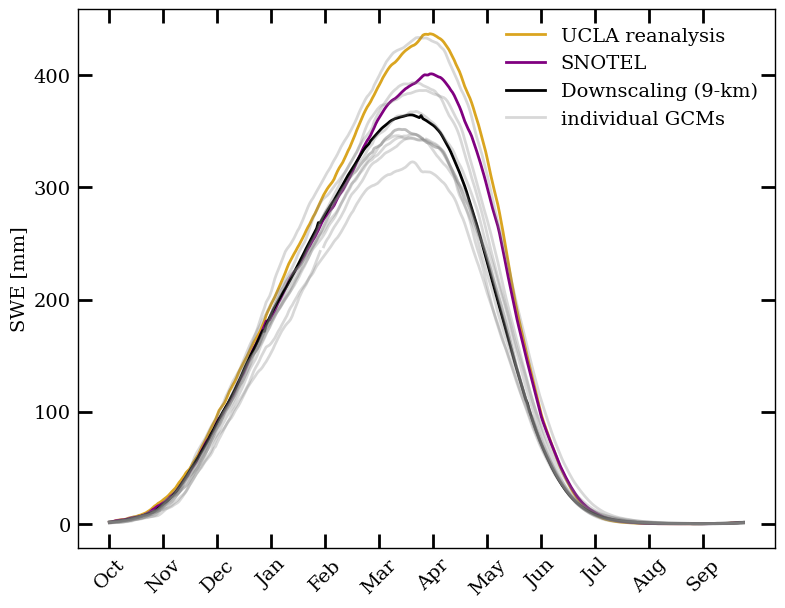

In [193]:
## make figure
wrfcolor = 'black'
snotelcolor = 'purple'
uclacolor = 'goldenrod'
## ucla data 

ucla_mean = np.nanmean(ucla_snotel_data['SWE'][:,0:30,:], axis = (0,1)) * 1000
ucla_sd = np.nanstd(ucla_snotel_data['SWE'][:,0:30,:], axis = (0,1)) * 1000

## snotel from WRF
shifted_wrf_mean = np.roll(wrf_snotel_daily_mean.values.flatten(), shift=90)
#shifted_wrf_sd = np.roll(wrf_snotel_daily_sd.values.flatten(), shift=90)

## snotel station data
snotel_mean = np.nanmean(meansnotel, axis = 1) * 24.5
snotel_sd = np.nanstd(meansnotel, axis = 1) * 24.5
shifted_snotel_mean = np.roll(snotel_mean, shift=92)
shifted_snotel_mean[91] = np.nanmean([shifted_snotel_mean[90], shifted_snotel_mean[92]])
shifted_snotel_sd = np.roll(snotel_sd, shift=92)


## dates ## 

x = np.arange(365)  # 0 to 364

# Create a list of month labels
month_labels = ['Oct', 'Nov', 'Dec','Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep']
## 

fig,ax = plt.subplots()
ax.plot(x, ucla_mean [0:365] , label = 'UCLA reanalysis', color = uclacolor)
ax.plot(x, shifted_snotel_mean[0:365] , label = 'SNOTEL', color = snotelcolor)
ax.plot(shifted_wrf_mean, label = 'Downscaling (9-km)', color = wrfcolor)

for gcm in all_snotelWRF.gcm:
    tmpdata = np.roll(snotel_from_WRF_BC.sel(gcm = gcm).mean(dim = 'site').swe, shift = 92)
    tmpdata[91] = np.nanmean([tmpdata[90], tmpdata[92]])
    ax.plot(tmpdata, color = 'gray', alpha = 0.3)
ax.plot(tmpdata, color = 'gray', alpha = 0.3, label = 'individual GCMs')

    
ax.set_ylabel('SWE [mm]')
ax.legend()
ax.set_xticks(np.arange(0, 365, 31), month_labels, rotation=45)

plt.show()



In [61]:
## PREP DATA ##
jjj = x_indices
iii = y_indices
snow_SNOTELfromWRF= []
for icount, igcm in enumerate(snow_BC.keys()):
    #Valid on the first of each month for each site
    snow_x = snow_BC[igcm].isel(lat2d=xr.DataArray(jjj,dims="site"), lon2d=xr.DataArray(iii,dims="site"))
    start_date = snow_x.time[5*365]  # 1985
    end_date = snow_x.time[35*365]   # 2015

    snow = snow_x.sel(time = slice(start_date,end_date))
    #snow = snow_x.sel(time=(snow_x.time.dt.day == 1)
    #                   ).load()
    
    if icount == 0:
        times = snow.time
        
    if icount != 0:
        snow['time'] = times
        
    snow_SNOTELfromWRF.append(snow)
    print (igcm)
    
snow_SNOTELfromWRF_BC = xr.concat(snow_SNOTELfromWRF,dim='gcm')
snow_SNOTELfromWRF_BC['gcm'] = keys

zSNOTEL = z_wrf.isel(lat2d=xr.DataArray(jjj,dims="site"), lon2d=xr.DataArray(iii,dims="site")).load()
z_coords = {'zWRF': (['site'],  zSNOTEL)}

print (snow_SNOTELfromWRF_BC)

gc.collect()
snotel_from_WRF_BC = snow_SNOTELfromWRF_BC.load()
snotel_from_WRF_BC.to_netcdf('snotel_from_WRF_BC.nc')


cesm2_r11i1p1f1_ssp370
mpi-esm1-2-lr_r7i1p1f1_ssp370
cnrm-esm2-1_r1i1p1f2_ssp370
ec-earth3-veg_r1i1p1f1_ssp370
fgoals-g3_r1i1p1f1_ssp370
ukesm1-0-ll_r2i1p1f2_ssp370
canesm5_r1i1p2f1_ssp370
access-cm2_r5i1p1f1_ssp370
ec-earth3_r1i1p1f1_ssp370
<xarray.DataArray (gcm: 9, time: 10951, site: 802)>
dask.array<concatenate, shape=(9, 10951, 802), dtype=float32, chunksize=(1, 334, 802), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 1985-09-01 00:00:00 ... 2015-09-01 00:00:00
  * gcm      (gcm) <U29 'cesm2_r11i1p1f1_ssp370' ... 'ec-earth3_r1i1p1f1_ssp370'
Dimensions without coordinates: site
Attributes:
    average_op_ncl:  dim_avg_n function was applied
    FieldType:       104
    MemoryOrder:     XY 
    units:           mm
    long_name:       snow water equivalent


In [62]:
jjj = x_indices
iii = y_indices
snow_SNOTELfromWRF= []
for icount, igcm in enumerate(snow_BC.keys()):

    #Valid on the first of each month for each site
    snow_x = snow_BC[igcm].isel(lat2d=xr.DataArray(jjj,dims="site"), lon2d=xr.DataArray(iii,dims="site"))
    #snow_x = snow_x.convert_calendar("365_day", align_on = 'year')

    #start_date = snow_x.time[0]
    #end_date = snow_x.time[30 * 365]
    calendar_type = snow_x.time[0].values.flatten()[0].calendar

    # Create cftime objects for the specified dates and calendar
    date_1985 = cftime.datetime(1985, 9, 1, calendar=calendar_type)
    date_2015 = cftime.datetime(2015, 9, 1, calendar=calendar_type)

    snow = snow_x.sel(time = slice(date_1985,date_2015))
    times = snow.time
        
    snow_SNOTELfromWRF.append(snow)
    print (igcm)
    

cesm2_r11i1p1f1_ssp370
mpi-esm1-2-lr_r7i1p1f1_ssp370
cnrm-esm2-1_r1i1p1f2_ssp370
ec-earth3-veg_r1i1p1f1_ssp370
fgoals-g3_r1i1p1f1_ssp370
ukesm1-0-ll_r2i1p1f2_ssp370
canesm5_r1i1p2f1_ssp370
access-cm2_r5i1p1f1_ssp370
ec-earth3_r1i1p1f1_ssp370


In [3]:
## load snotel locations from Fang paper
import scipy.io
## need to get daily snotel SWE from 
mat_data_best = scipy.io.loadmat('SNOTEL_SWE_WY1985_2021_high_res.mat')


daily_snotel_mean = xr.open_dataset('daily_wrf_snotel_mean.nc').rename({"__xarray_dataarray_variable__": 'snotel_mean'})
daily_snotel_sd = xr.open_dataset('daily_wrf_snotel_sd.nc').rename({"__xarray_dataarray_variable__": 'snotel_sd'})


## snotel data

file_list = glob.glob("../../snoteldata/snotel*.csv")
data = []
for file in file_list
    if file != '../../snoteldata/snotelmeta.csv':
        df = pd.read_csv(file, parse_dates = True)
        df['Date'] = pd.to_datetime(df['datetime'])
        df = df[(df['Date'].dt.year >= 1980) & (df['Date'].dt.year <= 2015)]
        data.append(df) 
snotel_df = pd.concat([df['SWE'] for df in data], axis=1)

gc.collect()

In [5]:

#Read meta
def _metaread(dir_meta,domain):
 file = "%swrfinput_%s" %(dir_meta,domain)
 data = xr.open_dataset(file)
 lat = data.variables["XLAT"]
 lon = data.variables["XLONG"]
 z = data.variables["HGT"]

 return (lat,lon,z,file)

#WRF reader function
def _wrfread(prefix,dir,var,domain,calendar):

 all_files = sorted(os.listdir(dir))

 anal_files = []
 for ii in all_files:
  if ii.startswith(var+"."):
   if domain in ii:
    if prefix in ii:
     anal_files.append(dir+str(ii))

 del all_files

 nf  = len(anal_files)

 data = xr.open_mfdataset(anal_files, combine="by_coords")
 var_read = data.variables[var]
 day = data.variables["day"].values
 nt = len(day)

 day1 = str ( int ( day[0] ) )
 val1 = day1[0:4]
 val2 = int (day1[4:6])
 val3 = int (day1[6:8])
 print (val1,val2,val3)
 day1_str = "%s-%s-%s" %(val1, "{:0=2d}".format(val2),
                                        "{:0=2d}".format(val3) )

 day2 = str ( int ( day[nt-1] ) )
 val1 = day2[0:4]
 val2 = int (day2[4:6])
 val3 = int (day2[6:8])
 print (val1,val2,val3)
 day2_str = "%s-%s-%s" %(val1, "{:0=2d}".format(val2),
                                        "{:0=2d}".format(val3) )
 time_array = xr.cftime_range(start=day1_str, end=day2_str,
                              freq="1D", calendar=calendar)


 var_read = xr.DataArray(var_read)
 var_read['day'] = time_array    #year doesn't matter here

 return (var_read.rename({'day': 'time'}))

#WRF tier 3 reader function
def _wrfread_gcm(model,gcm,variant,dir,var,domain,calendar):

 all_files = sorted(os.listdir(dir))

 anal_files = []
 for ii in all_files:
  if ii.startswith(var+".") and model in ii and gcm in ii \
        and variant in ii and domain in ii:
   if domain in ii:
     anal_files.append(dir+str(ii))

 del all_files

 nf  = len(anal_files)

 data = xr.open_mfdataset(anal_files, combine="by_coords")
 var_read = data.variables[var]
 day = data.variables["day"].values
 nt = len(day)

 day1 = str ( int ( day[0] ) )
 val1 = day1[0:4]
 val2 = int (day1[4:6])
 val3 = int (day1[6:8])
 day1_str = "%s-%s-%s" %(val1, "{:0=2d}".format(val2),
                                        "{:0=2d}".format(val3) )

 day2 = str ( int ( day[nt-1] ) )
 val1 = day2[0:4]
 val2 = int (day2[4:6])
 val3 = int (day2[6:8])
 day2_str = "%s-%s-%s" %(val1, "{:0=2d}".format(val2),
                                        "{:0=2d}".format(val3) )

 time_array = xr.cftime_range(start=day1_str, end=day2_str,
                              freq="1D", calendar=calendar)   

 var_read = xr.DataArray(var_read)
 var_read['day'] = time_array    #year doesn't matter here

 return (var_read)

def _read_merge(dir,domain,var,gcm,variant,date_start_hist, \
                date_start_ssp,date_end_hist,date_end_ssp,exp,bc,calendar):
    
    dir_x = "%s/%s_%s_historical/postprocess/" %(dir,gcm,variant) + domain + "/"
    
    if bc == True:
        dir_x = "%s/%s_%s_historical_bc/postprocess/" %(dir,gcm,variant) + domain + "/"

    if calendar == '360_day':
        date_end_hist = date_end_hist.split("-")
        date_end_hist = "%s-%s-%s" %(date_end_hist[0],
                                     date_end_hist[1],
                                     int( int(date_end_hist[2]) + 0.0001 - 1) )
        
        date_end_ssp = date_end_ssp.split("-")
        date_end_ssp = "%s-%s-%s" %(date_end_ssp[0],
                                     date_end_ssp[1],
                                     int( int(date_end_ssp[2]) + 0.0001 - 1) )
        
    print (calendar,date_end_hist,date_end_ssp)
    var_wrf = _wrfread_gcm("hist",gcm,variant,dir_x,var,domain,calendar)
    var_hist = var_wrf.sel(day=slice(date_start_hist,date_end_hist))
    dir_x = "%s/%s_%s_%s/postprocess/" %(dir,gcm,variant,exp) + domain + "/"
    
    print (gcm,variant,bc,exp)
    
    if bc == True:
        dir_x = "%s/%s_%s_%s_bc/postprocess/" %(dir,gcm,variant,exp) + domain + "/"

    var_wrf = _wrfread_gcm(exp,gcm,variant,dir_x,var,domain,calendar)
    var_ssp = var_wrf.sel(day=slice(date_start_ssp,date_end_ssp) )
    
    var_combine = xr.concat([var_hist,var_ssp],dim="day").rename({'day': 'time'})
    
    return (var_combine)

print ("Functions loaded")

Functions loaded


In [6]:
%%time

date_start_hist, date_end_hist = "1980-09-01", "2014-08-31"
date_start_ssp, date_end_ssp = "2014-09-01", "2100-08-31"

#These files contain all static fields
domain = "d02"
dir_meta = coorddir
lat1, lon1, z1, file = _metaread(dir_meta,domain)
lon_wrf = lon1[0,:,:]
lat_wrf = lat1[0,:,:]
z_wrf = z1[0,:,:]
lat_wrf = xr.DataArray(lat_wrf, dims=["lat2d", "lon2d"])
lon_wrf = xr.DataArray(lon_wrf, dims=["lat2d", "lon2d"])
z_wrf = xr.DataArray(z_wrf, dims=["lat2d", "lon2d"])

coords = {'lat': (['lat2d','lon2d'], lat_wrf), \
                 'lon': (['lat2d','lon2d'], lon_wrf) }

gcms = ['cesm2','mpi-esm1-2-lr','cnrm-esm2-1',
        'ec-earth3-veg','fgoals-g3','ukesm1-0-ll',
        'canesm5','access-cm2','ec-earth3' ]# ,
#        'miroc6','noresm2-mm','mpi-esm1-2-hr',
#        'taiesm1','giss-e2-1-g','cesm2','cesm2']

variants = ['r11i1p1f1','r7i1p1f1','r1i1p1f2',
            'r1i1p1f1','r1i1p1f1','r2i1p1f2',
            'r1i1p2f1','r5i1p1f1','r1i1p1f1',
            'r1i1p1f1','r1i1p1f1','r7i1p1f1',
            'r1i1p1f1','r1i1p1f2','r11i1p1f1',
            'r11i1p1f1']

calendar = ['365_day','proleptic_gregorian','proleptic_gregorian',
            'proleptic_gregorian','365_day','360_day',
             '365_day','proleptic_gregorian','proleptic_gregorian',
            'proleptic_gregorian','365_day', 'proleptic_gregorian',
            '365_day','365_day','365_day','365_day']

ssps = ['ssp370','ssp370','ssp370','ssp370',
        'ssp370','ssp370','ssp370','ssp370',
        'ssp370','ssp370','ssp370','ssp370',
        'ssp370','ssp370',
        'ssp245','ssp585']

print (len(ssps),len(calendar),len(variants),len(gcms))


p = np.array([1000, 925, 850, 800, 700, 600, 500, 400, 300, 250])
pressure = xr.DataArray(p,dims=['pressure'])

dir = projectdir

snow_noBC = {}
snow_BC = {}
snowApril1 = []
snowJan1 = []
snowJul1 = []

keys = []

for count, igcm in enumerate(gcms):
    
    condition = ()
    var = 'snow'
    key = '%s_%s_%s' %(igcm,variants[count],ssps[count])
    
    bc = True
    var = 'snow'
    var = _read_merge(dir,domain,var,
                                        igcm,variants[count], \
                                        date_start_hist,date_start_ssp, \
                                        date_end_hist,date_end_ssp,ssps[count],bc,
            calendar[count])# .assign_coords(coords)

    snow_BC[key] = var

    keys.append(key)
'''    
snowApril1 = xr.concat(snowApril1,dim='gcm')
snowApril1['gcm'] = keys

snowJul1 = xr.concat(snowJul1,dim='gcm')
snowJul1['gcm'] = keys

snowJan1 = xr.concat(snowJan1,dim='gcm')
snowJan1['gcm'] = keys
'''
gc.collect()

16 16 16 9
365_day 2014-08-31 2100-08-31
cesm2 r11i1p1f1 True ssp370
proleptic_gregorian 2014-08-31 2100-08-31
mpi-esm1-2-lr r7i1p1f1 True ssp370
proleptic_gregorian 2014-08-31 2100-08-31
cnrm-esm2-1 r1i1p1f2 True ssp370
proleptic_gregorian 2014-08-31 2100-08-31
ec-earth3-veg r1i1p1f1 True ssp370
365_day 2014-08-31 2100-08-31
fgoals-g3 r1i1p1f1 True ssp370
360_day 2014-08-30 2100-08-30
ukesm1-0-ll r2i1p1f2 True ssp370
365_day 2014-08-31 2100-08-31
canesm5 r1i1p2f1 True ssp370
proleptic_gregorian 2014-08-31 2100-08-31
access-cm2 r5i1p1f1 True ssp370
proleptic_gregorian 2014-08-31 2100-08-31
ec-earth3 r1i1p1f1 True ssp370
CPU times: user 6.49 s, sys: 2.85 s, total: 9.34 s
Wall time: 1min 56s


234

In [81]:
averages = []
std_deviations = []

for year in range(1980, 2020):
    year_data = [df[df['Date'].dt.year == year] for df in data][1:]
    concatenated_df = pd.concat([df.set_index('datetime')['SWE'] for df in year_data], axis=1, keys=range(len(year_data)))
    concatenated_df.columns = [f'SWE_{i}' for i in concatenated_df.columns.get_level_values(0)]


    year_average = np.mean([df['SWE'] for df in year_data], axis=1)
    year_std = np.std([df['SWE'] for df in year_data], axis=0)
    averages.append(year_average)
    std_deviations.append(year_std)

years = list(range(1980, 2016))


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (811,) + inhomogeneous part.

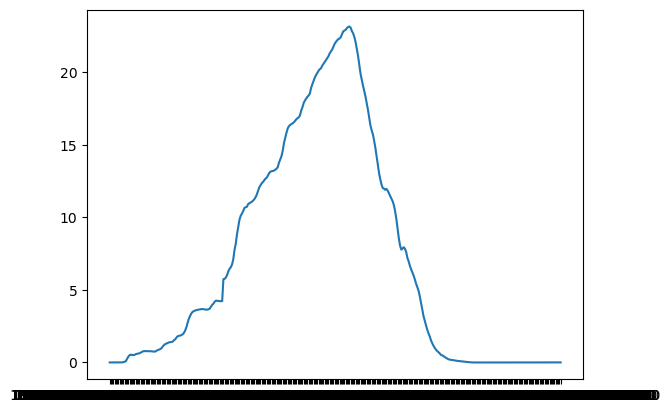

In [114]:
plt.plot(mean_values)

In [7]:
%%time
import cftime
snow_SNOTELfromWRF = []
import cftime

# Create cftime objects for the specified dates


var = 'snow'
#data = xr.open_dataset("./site_indices_%s_%s_%s.nc" %(var,domain,'ALL'))
#iii, jjj = data.ii_dim.values, data.jj_dim.values
NO
for icount, igcm in enumerate(snow_BC.keys()):

    #Valid on the first of each month for each site
    snow_x = snow_BC[igcm].isel(lat2d=xr.DataArray(jjj,dims="site"), lon2d=xr.DataArray(iii,dims="site"))
    #snow_x = snow_x.convert_calendar("365_day", align_on = 'year')

    #start_date = snow_x.time[0]
    #end_date = snow_x.time[30 * 365]
    calendar_type = snow_x.time[0].values.flatten()[0].calendar

    # Create cftime objects for the specified dates and calendar
    date_1985 = cftime.datetime(1985, 9, 1, calendar=calendar_type)
    date_2015 = cftime.datetime(2015, 9, 1, calendar=calendar_type)

    snow = snow_x.sel(time = slice(date_1985,date_2015))

    #if icount == 0:
    times = snow.time
        
    #if icount != 0:
    #    snow['time'] = times
        
    snow_SNOTELfromWRF.append(snow)
    print (igcm)
    
#snow_SNOTELfromWRF_BC = xr.concat(snow_SNOTELfromWRF,dim='gcm')
#snow_SNOTELfromWRF_BC['gcm'] = keys

#zSNOTEL = z_wrf.isel(lat2d=xr.DataArray(jjj,dims="site"), lon2d=xr.DataArray(iii,dims="site")).load()
#z_coords = {'zWRF': (['site'],  zSNOTEL)}

# print (snow_SNOTELfromWRF_BC)

gc.collect()

cesm2_r11i1p1f1_ssp370
mpi-esm1-2-lr_r7i1p1f1_ssp370
cnrm-esm2-1_r1i1p1f2_ssp370
ec-earth3-veg_r1i1p1f1_ssp370
fgoals-g3_r1i1p1f1_ssp370
ukesm1-0-ll_r2i1p1f2_ssp370
canesm5_r1i1p2f1_ssp370
access-cm2_r5i1p1f1_ssp370
ec-earth3_r1i1p1f1_ssp370
CPU times: user 509 ms, sys: 3.96 ms, total: 513 ms
Wall time: 531 ms


9

In [103]:
allwrfsnoteldoy = []
for i in range(9):
    mydata = snow_SNOTELfromWRF[i]
    mean = mydata.groupby(mydata.time.dt.dayofyear).mean()
    allwrfsnoteldoy.append(mean)

In [101]:
'''
January - 31 days
February - 28 days in a common year and 29 days in leap years
March - 31 days
April - 30 days
May - 31 days
June - 30 days
July - 31 days
August - 31 days
September - 30 days
October - 31 days
November - 30 days
December - 31 days
'''
def convert_360_to_365(indata):
    outdata = np.zeros((365, 802))
    nans = np.full((1,802), np.nan)
    outdata[0:30] = indata[0:30] #jan
    outdata[30] = nans #jan
    outdata[31:89] = indata[30:88] #feb, march
    outdata[89] = nans # march
    outdata[90:150] = indata[90:150] #april, may
    outdata[150] = nans #may
    outdata[151:211] = indata[150:210] #june july
    outdata[211] = nans # july
    outdata[212:242] = indata[210:240] #august
    outdata[242] = nans # september
    outdata[243:303] = indata[240:300] #september, october
    outdata[303] = nans # october
    outdata[304:364] = indata[300:360] #november, december
    outdata[364] = nans # december
    return outdata

'''
jan: [0:30] np.nan
feb, march: [30:30+28+30] np.nan 
        
april, may: [30+28+30:30+28+60] np.nan
june, july: [30+28+60:30+28+120] np.nan
                             
august:  [30+28+120:30+28+150] np.nan
september, october: [30+28+150:30+28+210] np.nan
november, december: [30+28+210:30+28+270] np.nan


jan: + 31
feb: lose 29 and 30
march: +31
april: ok
may: + 31
june: ok
july: +31
august: +31
september: ok
october: +31
november: ok
december: +31
'''

'\njan: [0:30] np.nan\nfeb, march: [30:30+28+30] np.nan \n        \napril, may: [30+28+30:30+28+60] np.nan\njune, july: [30+28+60:30+28+120] np.nan\n                             \naugust:  [30+28+120:30+28+150] np.nan\nseptember, october: [30+28+150:30+28+210] np.nan\nnovember, december: [30+28+210:30+28+270] np.nan\n\n\njan: + 31\nfeb: lose 29 and 30\nmarch: +31\napril: ok\nmay: + 31\njune: ok\njuly: +31\naugust: +31\nseptember: ok\noctober: +31\nnovember: ok\ndecember: +31\n'

In [125]:
on_365 = []
for entry in allwrfsnoteldoy:
    entry = entry.load()
    print(len(entry))
    if len(entry) == 366:
        entry = entry.isel(dayofyear=slice(0, 60)).combine_first(entry.isel(dayofyear=slice(61, None)))
    elif len(entry) == 360:
        entry = convert_360_to_365(entry)
    on_365.append(entry)    

365
366
366
366
365
360
365
366
366


(9, 365, 802)

In [126]:
tmp = on_365[0].copy()
tmp.values = on_365[5]
on_365[5] = tmp

In [165]:
for entry in on_365:
    entry['dayofyear'] = range(0,365)
all_snotelWRF = xr.concat(on_365, dim = 'gcm')


In [168]:
all_snotelWRF.to_netcdf('all_snotelWRF_365.nc')

In [ ]:
base_times = snow_SNOTELfromWRF[1].time
base_year = snow_SNOTELfromWRF[1].time.dt.year
base_month = snow_SNOTELfromWRF[1].time.dt.month
base_day = snow_SNOTELfromWRF[1].time.dt.day
import numpy as np

# Initialize empty lists to store data for each date
output_list = []
date = base_times[0]
wrfdata = snow_SNOTELfromWRF[1]
target_date = cftime.datetime(date.dt.year, date.dt.month, date.dt.day, calendar = calendar_type)
data_for_date = wrfdata.sel(time=target_date, method = 'nearest')
save_val = data_for_date
empty_data_array = np.full(data_for_date.values.shape, np.nan)
save_val.values = empty_data_array

for i in [0,4,5,6]:
    wrfdata = snow_SNOTELfromWRF[i]
    calendar_type = wrfdata.time[0].values.flatten()[0].calendar
    # Iterate through base_times to process each date
    for date in base_times:
        try:
            target_date = cftime.datetime(date.dt.year, date.dt.month, date.dt.day, calendar = calendar_type)
            data_for_date = wrfdata.sel(time=target_date, method = 'nearest').values
        except:
            data_for_date = save_val.values
        dataarray_for_date = data_for_date
        output_list.append(dataarray_for_date)

In [ ]:
1

In [413]:
idxs = {0: [0,10958*1],
        4: [10958*1,10958*2],
        5:[10958*2,10958*3],
        6:[10958*4,10958*5]}

In [415]:
allwrfs=[]
for i in range(9):
    if i in [0,4,5,6]:
        wrfdata = output_list[idxs[i][0]:idxs[i][1]]
    else:
        wrfdata = snow_SNOTELfromWRF[i]
    allwrfs.append(wrfdata)

In [449]:
all_snotelWRF

<xarray.DataArray 'time' ()>
array(cftime.DatetimeNoLeap(1988, 3, 1, 0, 0, 0, 0, has_year_zero=True),
      dtype=object)
Coordinates:
    time     object 1988-03-01 00:00:00

10951
10958
10958
10958
10951
10801
10951
10958
10958


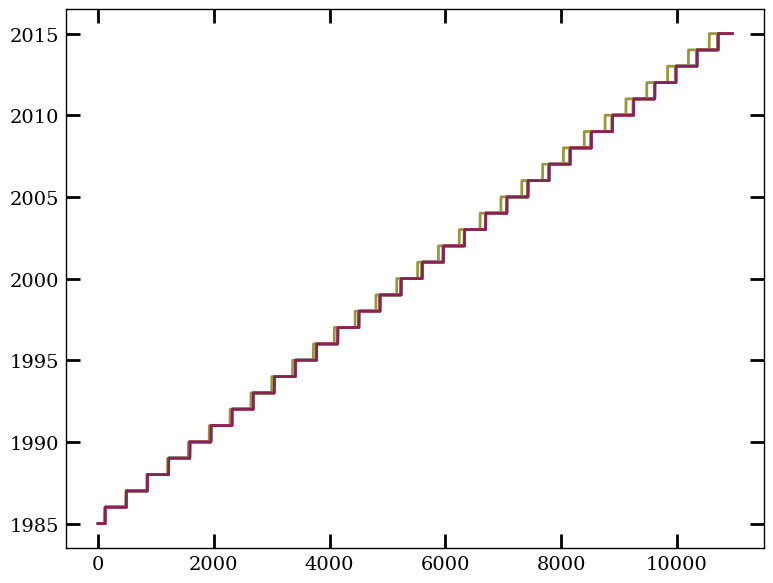

In [396]:
years = snow_SNOTELfromWRF[0].time.dt.year
months = snow_SNOTELfromWRF[0].time.dt.month
days = snow_SNOTELfromWRF[0].time.dt.day
for i in range(9):
    years2 = snow_SNOTELfromWRF[i].time.dt.year
    months2 = snow_SNOTELfromWRF[i].time.dt.month
    days2 = snow_SNOTELfromWRF[i].time.dt.day
    plt.plot(years2)
    print(len(years2))

In [393]:
len(years2)

10951

In [379]:
times

<xarray.DataArray 'time' (time: 10951)>
array([cftime.DatetimeNoLeap(1985, 9, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1985, 9, 2, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1985, 9, 3, 0, 0, 0, 0, has_year_zero=True), ...,
       cftime.DatetimeNoLeap(2015, 8, 30, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2015, 8, 31, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2015, 9, 1, 0, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
  * time     (time) object 1985-09-01 00:00:00 ... 2015-09-01 00:00:00

<xarray.DataArray (time: 43800, site: 703)>
dask.array<where, shape=(43800, 703), dtype=float32, chunksize=(365, 703), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 1980-09-01 00:00:00 ... 2100-08-31 00:00:00
Dimensions without coordinates: site
Attributes:
    average_op_ncl:  dim_avg_n function was applied
    FieldType:       104
    MemoryOrder:     XY 
    units:           mm
    long_name:       snow water equivalent

'proleptic_gregorian'

In [51]:
## this takes a while, do this and then save 
snotel_from_WRF_BC = snow_SNOTELfromWRF_BC.load()
snotel_from_WRF_BC.to_netcdf('snotel_from_WRF_BC.nc')
'''
daily_snotel_mean = snow_SNOTELfromWRF_BC.mean(dim = 'gcm').mean(dim = 'site').groupby(snow_SNOTELfromWRF_BC.time.dt.strftime('%m-%d')).mean().load()
daily_snotel_sd = snow_SNOTELfromWRF_BC.mean(dim = 'gcm').mean(dim = 'site').groupby(snow_SNOTELfromWRF_BC.time.dt.strftime('%m-%d')).std().load()
daily_snotel_mean.to_netcdf('daily_wrf_snotel_mean.nc')
daily_snotel_sd.to_netcdf('daily_wrf_snotel_sd.nc')
'''

In [115]:
from datetime import datetime, timedelta

# Define the start date as September 1 of the current year
start_date = datetime(datetime.now().year, 9, 1)

# Create an empty list to store the dates
dates_one_year = []

# Iterate for one year and append each date to the list
for _ in range(365):
    dates_one_year.append(start_date)
    start_date += timedelta(days=1)


In [125]:
daily_snotel_mean.values

AttributeError: 'numpy.ndarray' object has no attribute 'roll'

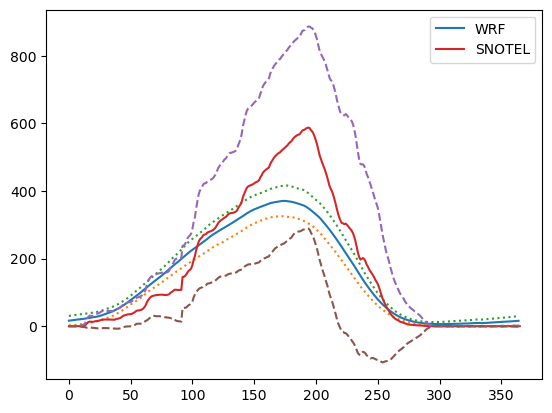

In [ ]:

fig,ax = plt.subplots()
ax.plot(daily_snotel_mean)
plt.show()

In [118]:
mean_values.datetime

AttributeError: 'Series' object has no attribute 'datetime'